#  Aprimorando o Modelo de Machine Learning

## Aplicando validação cruzada e ajustando os hiperâmetros do modelo (Dataset do Titanic).

---

Neste *Notebook* trago uma espécie de continuação e aprimoramento do *Notebook* [Iniciando em Machine Learning com a Competição do Titanic](https://github.com/JairOliveira2014/My_data_science/blob/master/Titanic/Titanic_Kaggle.ipynb) disponível no meu repositório do Github.

<img src="https://i.imgur.com/ESXUQsB.jpg[/img]" width=600>

Caso não tenha lido os dois artigos inscritos sobre a parte do *Notebook* mencionado acima, pode dar um pulo lá, pois, irá somar muito no entendimento.

   1.[Iniciando em Machine Learning com o desafio do Titanic [Parte I]](https://medium.com/@jair.oliveira1204/iniciando-em-machine-learning-com-o-desafio-do-titanic-parte-i-bbec3f03e4a0).
   
   2.[Iniciando em Machine Learning com o desafio do Titanic [Parte II]](https://medium.com/@jair.oliveira1204/iniciando-em-machine-learning-com-o-desafio-do-titanic-parte-ii-9a58d5a75eab).

Neste *Notebook* não abordarei a parte de definição de problema do desafio do kaggle, obteção de dados e análise exploratória (abordei com mais detalhes estas etapas nos artigos acima). 

Nosso foco aqui, é apresentar algumas técnicas diferentes na tratativa dos dados, aplicar a validação cruzada que é de suma importância, pois no outro material validamos com os dados que havíamos treinado e por último, ajustaremos os hiperparâmetros pelos métodos *Random Search* e Otimização Bayesiana.

O objetivo é que após estudar este material, você poderá transportar para projetos futuros o conhecimento adquirido neste *Notebook* e levar para outro nível suas validações e ajustes de hiperparâmetros.

Vamos lá aprender juntos!

In [76]:
# Importando as bibliotecas que usaremos

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import RepeatedKFold

from skopt import dummy_minimize
from skopt import gp_minimize
from skopt.plots import plot_convergence
from sklearn.metrics import roc_auc_score

In [2]:
# Carregando os Dataset's

df_train = pd.read_csv('Dados/train.csv')
df_test = pd.read_csv('Dados/test.csv')

# Criando a combinação nos dois Dataset's

data_combine = [df_train, df_test]

In [3]:
# Exibindo as primeiras linhas do Dataset

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Verificando o *shape* dos dados

df_train.shape, df_test.shape

((891, 12), (418, 11))

De fato, esse *Dataset* é pequeno o que vai nos limitar quando formos trabalhar recursos de validação.

Como podemos ver os dados de treino possuem 891 linhas e 11 *features* e a variável *target*.

Já os dados de teste é composto por 418 linhas e 11 *features*, pois, é aqui que faremos nossas previsões.

In [5]:
# Lembrando de verificar as principais informações estatísticas

df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Para finalizar aqueles códigos "obrigatórios" em toda exploração inicial, iremos verificar agora os 
tipos de dados e as *features* com *missing values* para os dois *Dataset's*.

In [6]:
""" Criando um DataFrame para entender os tipos de dados 
    e os valores missing no Dataset train"""

df_aux_train = pd.DataFrame({'Colunas': df_train.columns,
                       'Tipos': df_train.dtypes,
                       'Percentual_faltantes': df_train.isna().sum() / df_train.shape[0]})
df_aux_train

,Colunas,Tipos,Percentual_faltantes
PassengerId,PassengerId,int64,0.000000
Survived,Survived,int64,0.000000
Pclass,Pclass,int64,0.000000
Name,Name,object,0.000000
Sex,Sex,object,0.000000
Age,Age,float64,0.198653
SibSp,SibSp,int64,0.000000
Parch,Parch,int64,0.000000
Ticket,Ticket,object,0.000000
Fare,Fare,float64,0.000000


In [7]:
""" Criando um DataFrame para entender os tipos de dados 
    e os valores missing no Dataset test"""

df_aux_test = pd.DataFrame({'colunas': df_test.columns,
                            'tipos': df_test.dtypes,
                            'Percentual_faltantes': df_test.isna().sum() / df_test.shape[0]})
df_aux_test

,colunas,tipos,Percentual_faltantes
PassengerId,PassengerId,int64,0.000000
Pclass,Pclass,int64,0.000000
Name,Name,object,0.000000
Sex,Sex,object,0.000000
Age,Age,float64,0.205742
SibSp,SibSp,int64,0.000000
Parch,Parch,int64,0.000000
Ticket,Ticket,object,0.000000
Fare,Fare,float64,0.002392
Cabin,Cabin,object,0.782297


Como podemos verificar, os *Dataset's* *train* e *test* detêm as maiores quantidades de valores nulos nas *features* ```Age```e ```Cabin``` chegando a mais de 77% nesta última. Já para as *features*  ```Embarked``` e ```Fare``` possuem uma quantidade pequena de dados em seus conjuntos, o que não será um problema tratá-los. 

### Recordando

Esses são pontos que concluímos da nossa análise exploratória em cima dos dados (podes verificar nos artigos citados anteriormente).

Nossas suposições com base na descrição do problema observada anteriormente.

    As mulheres (Sex = 'female') foram mais propensas a sobreviver.
    As crianças tiveram maior probabilidade de sobreviver.
    Os passageiros da classe alta (Pclass = 1) tiveram maior probabilidade de sobreviver.
    

Observações

    Pclass = 3 teve a maioria dos passageiros, porém a maioria não sobreviveu.
    A maioria dos passageiros da Pclass = 1 sobreviveu.
    A classe varia em termos de distribuição etária dos passageiros.

Agora que carregamos nossos dados, verificamos e relembramos nossas conclusões estamos prontos para começarmos!

Vamos iniciar lidando com os *missing values*.

## Lindando com *Missing Values*

No artigo que publiquei recentemente, o único trabalho que fizemos com os dados faltantes foi preencher com a mediana na variávei ```Age``` e o *drop* na variável ```Embarked``` para os dados de treinamento. Já para os dados de teste também preenchemos com a mediana para a variável ```Age``` e para ```Fare```.

Não usamos as *features* ```PassengerId```, ```Ticket``` e ```Cabin```, lembrando que esta última não escolhemos pelo grande percentual de *missing values*. Neste aqui também não usaremos essas mesmas *features*, continuaremos com o nosso foco na validação e escolha dos hiperparâmetros.

Antes de realizar a remoção temos que guardar a variável *target* e a *feature* ```PassengerId``` pois iremos precisar mais tarde.

In [8]:
#  fazendo o 'drop' das 'features' para os dados de treino

df_train.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [9]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [10]:
# Guardando a 'feature passengerId' e fazendo o 'drop' das outras 'features'

passengerId = df_test['PassengerId']

df_test.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [11]:
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S


###  Variável *Age*

Ambos os *Datasets* de treino e teste contêm aproximadamente 20% dos seus dados ausentes.

Dessa vez, não vamos apenas substituir pela média ou mediana global, vamos substituir pelos valores relativos as médias de cada grupo correlacionado com  ```Sex``` x ```Pclass```.

In [12]:
# Agrupando pelo Sex e Age

df_train[['Sex', 'Age', 'Pclass']].groupby(['Sex', 'Pclass'], as_index=False).mean()

,Sex,Pclass,Age
0,female,1,34.611765
1,female,2,28.722973
2,female,3,21.750000
3,male,1,41.281386
4,male,2,30.740707
5,male,3,26.507589


Como imaginávamos, as médias das idades mudam em relação ao sexo e a classe de cada passageiro.

Podemos considerar os seguintes métodos para tratar os *missing values*

    1. Uma maneira simples é gerar valores aleatórios entre média e desvio padrão.

    2. Uma maneira mais precisa de preencher valores ausentes é usar outros recursos correlatos. No nosso caso, observamos correlação entre Idade, Gênero e Classe. Adivinhar valores de idade usando valores de média para a idade em conjuntos de combinações de recursos de classe e gênero. Então, a média da idade da classe 1 = e gênero = 0, classe = 1 e gênero = 1, e assim por diante ...

O método 1 introduzirá ruído aleatório em nosso modelo, pois, os resultados de várias execuções podem variar. Sendo assim, nós usaremos o método 2.

Vamos começar convertendo a *feature* ```Sex```, onde feminino = 1 e masculino = 0.


In [13]:
# Mudando os dados catégoricos para númericos

for dataset in data_combine:
    dataset['Sex'] = dataset["Sex"].map({'male': 0, 'female': 1}).astype(int)

df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S


Conforme já escolhido acima usaremos uma técnica mais precisa, já que, relacionaremos com outras *features* e isso nos dará menos variações e ruídos nos dados.

Vamos começar preparando uma matriz vazia para conter valores de idade calculados com base nas combinações ```Pclass``` x ```Gênero```.

In [14]:
mat_age = np.zeros((2,3))
mat_age

array([[0., 0., 0.],
       [0., 0., 0.]])

Agora que criamos nossa matriz faremos um *Loop* com as linhas e colunas, criaremos um *Dataset* com os valores das idades para cada intervalo e depois faremos a média e salvaremos na matriz.

Por último recuperaremos os valores e preencheremos onde encontrarmos com **NAN** e com respectivos sexos e classes.

In [15]:
for dataset in data_combine:
    for i in range(0, 2):
        for j in range(0, 3):
            df_age = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()
            
            age_encont = df_age.mean()
            
            mat_age[i, j] = age_encont
    
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[(dataset['Age'].isna()) & (dataset['Sex'] == i) & (dataset['Pclass'] == j+1),
                       'Age'] = mat_age[i, j]
    dataset['Age'] = dataset['Age'].astype(int)
    
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,22,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",1,26,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",0,35,0,0,8.0500,S


### Variável *Embarked*

A variável ```Embarked``` possui valores S, Q, C com base no porto de embarque. 
Nosso conjunto de dados de treinamento tem dois valores ausentes. Nós simplesmente os preenchemos com a ocorrência mais comum.



In [16]:
freq_emb = df_train['Embarked'].mode().dropna()[0]

df_train['Embarked'].fillna(freq_emb, inplace=True)

### Variável *Fare*

Agora podemos concluir com a variável ```Fare``` para um único valor ausente no conjunto de dados de teste usando a média. Faremos isso em uma única linha de código.


In [17]:
df_test.fillna(df_test['Fare'].dropna().mean(), inplace=True)

Assim, podemos verificar que não há mais dados ausentes nos nossos *Datasets*.

In [18]:
# Dados de test

df_test.isna().sum()

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [19]:
# Dados de treino

df_train.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

## Modelando os dados

Depois que finalizamos todas as tratativas com os dados ausentes, podemos tratar das traformações e criação de novas *features*.


### Transformando dados categóricos em numéricos

Agora podemos converter recursos que contêm cadeias de caracteres em valores numéricos. 

A maioria dos modelos vai exigir alguma tratativa com os dados categóricos, afinal os modelos são fórmulas matemáticas e estatísticas.

#### Variável *Name*

Iremos analisar a *feature* ```Name``` e extrair os títulos, em seguidas verificaremos a correlação entre os títulos e sobrevivência.

No código a seguir, extraímos o recurso Título usando expressões regulares. O padrão *RegEx* ('w + \ .') corresponde à primeira palavra que termina com um caractere de ponto no nome. O sinalizador **expand = False** retorna um *DataFrame.*

Observações

Quando traçamos Título e Sobreviventes, temos as seguintes observações.

    Títulos como 'Miss' e 'Mrs' tiveram uma quantide significante de sobreviventes.
    Títulos como 'Master' e 'Mr' tem uma grande quantidade de não sobreviventes.

Decisão.

    Decidimos manter o novo recurso Título para o treinamento do modelo.



In [20]:
# Extraindo os títulos e verificando a relação com os sobreviventes

data_combine = [df_train, df_test]

for dataset in data_combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(df_train['Title'], df_train['Sex'])

Sex,0,1
Title,,
Capt,1,0
Col,2,0
Countess,0,1
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,0,1
Major,2,0
Master,40,0


Podemos substituir muitos títulos por um nome mais comum e os demais classificá-los como *Rare*.

In [21]:
# Substituindo os títulos e mantendo os comuns

for dataset in data_combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
         'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
df_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Como vemos acima alguns títulos tem pouca probabilidade de sobrevivência, já outros chegam à 79% em média.

Vamos substituir os valores categóricos por númericos e prencheremos os dados com **NAN** com 0.

In [22]:
title = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data_combine:
    dataset['Title'] = dataset['Title'].map(title)
    
    # preenchendo NaN com 0
    dataset['Title'] = dataset['Title'].fillna(0)

df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",0,22,1,0,7.2500,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,71.2833,C,3
2,1,3,"Heikkinen, Miss. Laina",1,26,0,0,7.9250,S,2
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,53.1000,S,3
4,0,3,"Allen, Mr. William Henry",0,35,0,0,8.0500,S,1


Agora, podemos descartar com segurança a variável ```Name``` dos conjuntos de dados de treinamento e teste.

In [23]:
df_train.drop(['Name'], axis=1, inplace=True)
df_test.drop(['Name'], axis=1, inplace=True)

data_combine = [df_train, df_test]

In [24]:
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,0,34,0,0,7.8292,Q,1
1,3,1,47,1,0,7.0000,S,3
2,2,0,62,0,0,9.6875,Q,1
3,3,0,27,0,0,8.6625,S,1
4,3,1,22,1,1,12.2875,S,3


####  Variável *Embarked*


Agora podemos converter os valores categóricos em númericos da variável ```Embarked``` assim como fizemos com a ```Sex```.

In [25]:
# Substituindo os valores

for dataset in data_combine:
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

Uma das formas mais simples de representação de variáveis categóricas é através do processo de *dummies*, onde o próprio pandas já possui um objeto que facilita a implementação. 

Com ele, uma variável categórica com ℎ categorias é transformada em ℎ novas variáveis binárias (0 ou 1). Dessa forma, tranformamos nossas variáveis em binárias, onde a presença do 1  significa que aquela observação pertence àquela categoria, e 0 que não pertence. 

In [33]:
# Criando para o conjunto de dados de treinamento

embarked_dummies = pd.get_dummies(df_train['Embarked'], prefix='Embarked')

# concatenando os dados
df_train = pd.concat([df_train, embarked_dummies], axis=1)

# excluindo a variável 'Embarked'
df_train.drop(['Embarked'], axis=1, inplace=True)

In [32]:
#Criando para o conjunto de dados de testes

embarked_dummies = pd.get_dummies(df_test['Embarked'], prefix='Embarked')

# concatenando os dados
df_test = pd.concat([df_test, embarked_dummies], axis=1)

# excluindo a variável 'Embarked'
df_test.drop(['Embarked'], axis=1, inplace=True)

In [28]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Embarked_0,Embarked_1,Embarked_2
0,0,3,0,22,1,0,7.2500,1,1,0,0
1,1,1,1,38,1,0,71.2833,3,0,1,0
2,1,3,1,26,0,0,7.9250,2,1,0,0
3,1,1,1,35,1,0,53.1000,3,1,0,0
4,0,3,0,35,0,0,8.0500,1,1,0,0


In [29]:
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Embarked_0,Embarked_1,Embarked_2
0,3,0,34,0,0,7.8292,1,0,0,1
1,3,1,47,1,0,7.0000,3,1,0,0
2,2,0,62,0,0,9.6875,1,0,0,1
3,3,0,27,0,0,8.6625,1,1,0,0
4,3,1,22,1,1,12.2875,3,1,0,0


### Criando intervalos categóricos (Discretização)

Agora que lidamos com os valores ausentes e transformamos nossos dados podemos conhecer um recurso novo.

Discretização, é o processo de transformar variáveis contínuas em variáveis categóricas. Este recurso é útil para converter uma variável numérica em categórica, quando o valor exato numérico não for tão importante quanto o intervalo onde ele se encontra.

Podemos criar intervalos que contenham aproximadamente a mesma quantidade de observações, utilizando a estratégia quartil ou que sejam igualmente espaçados com a estratégia *uniform*.

A seguir lidaremos com a variável ```Age``` e ```Fare``` com esse recurso.

#### Variável *Age*

Vamos aplicar o conceito de discretização utilizando o **pd.cut**, iremos dividir em 5 intervalos, já o que julgamos importante não é a idade em si e sim o intervalo na qual ela se encaixa.

Obs.: Lembra da observação de que crianças tinham maiores chance? pois bem, separando em intervalos evidenciará melhor para o modelo.

In [34]:
# Criando os intervalos usando o pandas

df_train['AgeBand'] = pd.cut(df_train['Age'], 5)

In [35]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Embarked_0,Embarked_1,Embarked_2,AgeBand
0,0,3,0,22,1,0,7.2500,1,1,0,0,"(16.0, 32.0]"
1,1,1,1,38,1,0,71.2833,3,0,1,0,"(32.0, 48.0]"
2,1,3,1,26,0,0,7.9250,2,1,0,0,"(16.0, 32.0]"
3,1,1,1,35,1,0,53.1000,3,1,0,0,"(32.0, 48.0]"
4,0,3,0,35,0,0,8.0500,1,1,0,0,"(32.0, 48.0]"


In [36]:
# Verificando a quantidade de recursos intervalo

df_train['AgeBand'].value_counts()

(16.0, 32.0]     495
(32.0, 48.0]     216
(-0.08, 16.0]    100
(48.0, 64.0]      69
(64.0, 80.0]      11
Name: AgeBand, dtype: int64

Podemos aplicar a transformação para cada intervalo.

In [37]:
# Aplicando a transformação para todos os dados

data_combine = [df_train, df_test]
for dataset in data_combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
    
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Embarked_0,Embarked_1,Embarked_2,AgeBand
0,0,3,0,1,1,0,7.2500,1,1,0,0,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,3,0,1,0,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,2,1,0,0,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,3,1,0,0,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,1,1,0,0,"(32.0, 48.0]"


Podemos também fazer o *drop* da variável ```AgeBand```.

In [38]:
df_train.drop(['AgeBand'], axis=1, inplace=True)

data_combine = [df_train, df_test]

df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Embarked_0,Embarked_1,Embarked_2
0,0,3,0,1,1,0,7.2500,1,1,0,0
1,1,1,1,2,1,0,71.2833,3,0,1,0
2,1,3,1,1,0,0,7.9250,2,1,0,0
3,1,1,1,2,1,0,53.1000,3,1,0,0
4,0,3,0,2,0,0,8.0500,1,1,0,0


#### Variável *Fare*

Agora podemos concluir a *feature* ```Fare```, nela utilizaremos a função de discretização baseada em quartis, pois nos resultará em intervalos com tamanhos iguais de dados.



In [39]:
# aplicando intervalos com base nos quartis

df_train['FareBand'] = pd.qcut(df_train['Fare'], 4)

In [40]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Embarked_0,Embarked_1,Embarked_2,FareBand
0,0,3,0,1,1,0,7.2500,1,1,0,0,"(-0.001, 7.91]"
1,1,1,1,2,1,0,71.2833,3,0,1,0,"(31.0, 512.329]"
2,1,3,1,1,0,0,7.9250,2,1,0,0,"(7.91, 14.454]"
3,1,1,1,2,1,0,53.1000,3,1,0,0,"(31.0, 512.329]"
4,0,3,0,2,0,0,8.0500,1,1,0,0,"(7.91, 14.454]"


In [41]:
df_train['FareBand'].value_counts()

(7.91, 14.454]     224
(-0.001, 7.91]     223
(31.0, 512.329]    222
(14.454, 31.0]     222
Name: FareBand, dtype: int64

Podemos agora converter a *feature* ```Fare``` baseada na ```FareBand```.


In [42]:
# Aplicando a mudança dos dados com base nos intervalos

for dataset in data_combine:
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare' ] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 31), 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
df_train.drop(['FareBand'], axis=1, inplace=True)

data_combine = [df_train, df_test]
    
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Embarked_0,Embarked_1,Embarked_2
0,0,3,0,1,1,0,0,1,1,0,0
1,1,1,1,2,1,0,3,3,0,1,0
2,1,3,1,1,0,0,1,2,1,0,0
3,1,1,1,2,1,0,3,3,1,0,0
4,0,3,0,2,0,0,1,1,1,0,0


In [43]:
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Embarked_0,Embarked_1,Embarked_2
0,3,0,2,0,0,0,1,0,0,1
1,3,1,2,1,0,0,3,1,0,0
2,2,0,3,0,0,1,1,0,0,1
3,3,0,1,0,0,1,1,1,0,0
4,3,1,1,1,1,1,3,1,0,0


### Criando novas *features* com base nas existentes

#### Family

Podemos criar uma nova *feature* chamada ```Family``` que combina ```Parch``` e ```SibSp```. 
Isso nos permitirá remover ```Parch``` e ```SibSp``` de nossos conjuntos de dados. 

Nota: Aconselho você testar com as duas variáveis e depois criando está última com base nelas, veja o que acontece.

In [44]:
# Criando a variável 'Family'

for dataset in data_combine:
    dataset['Family'] = dataset['SibSp'] + dataset['Parch'] + 1

In [45]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Embarked_0,Embarked_1,Embarked_2,Family
0,0,3,0,1,1,0,0,1,1,0,0,2
1,1,1,1,2,1,0,3,3,0,1,0,2
2,1,3,1,1,0,0,1,2,1,0,0,1
3,1,1,1,2,1,0,3,3,1,0,0,2
4,0,3,0,2,0,0,1,1,1,0,0,1


Agora podemos fazer o *drop* das variáveis ```SibSp```, ```Parch```.

In [46]:
df_train.drop(['SibSp', 'Parch'], axis=1, inplace=True)
df_test.drop(['SibSp', 'Parch'], axis=1, inplace=True)
data_combine = [df_train, df_test]

df_train.head()

,Survived,Pclass,Sex,Age,Fare,Title,Embarked_0,Embarked_1,Embarked_2,Family
0,0,3,0,1,0,1,1,0,0,2
1,1,1,1,2,3,3,0,1,0,2
2,1,3,1,1,1,2,1,0,0,1
3,1,1,1,2,3,3,1,0,0,2
4,0,3,0,2,1,1,1,0,0,1


#### Age_Pclass


Agora vamos criar uma variável artificial usando ```Age``` e ```Pclass``` que estão entre as principais *features* com maiores correlação com os sobreviventes.




In [47]:
# Criando a nova variável

for dataset in data_combine:
    dataset['Age_Class']= dataset['Age'] * dataset['Pclass']

In [48]:
df_train.head()

,Survived,Pclass,Sex,Age,Fare,Title,Embarked_0,Embarked_1,Embarked_2,Family,Age_Class
0,0,3,0,1,0,1,1,0,0,2,3
1,1,1,1,2,3,3,0,1,0,2,2
2,1,3,1,1,1,2,1,0,0,1,3
3,1,1,1,2,3,3,1,0,0,2,2
4,0,3,0,2,1,1,1,0,0,1,6


In [49]:
df_test.head()

,Pclass,Sex,Age,Fare,Title,Embarked_0,Embarked_1,Embarked_2,Family,Age_Class
0,3,0,2,0,1,0,0,1,1,6
1,3,1,2,0,3,1,0,0,2,6
2,2,0,3,1,1,0,0,1,1,6
3,3,0,1,1,1,1,0,0,1,3
4,3,1,1,1,3,1,0,0,3,3


Como é possível observar, dessa vez estudamos e desenvolvemos algumas técnicas de *features engineering*, tratamos os dados de formas diferentes, criamos novos recursos e etc.

Agora vamos aplicar um modelo de validação dos dados, afinal, cada vez que você fizer uma pequena alteração precisará entender o que mudou no modelo e na vida real não temos a oportunidade de "submeter" cada vez que precisarmos.

Como vemos acima, nossos *Datasets* resultantes estão bem diferentes, muitos conceitos por trás, você aprofundar e tenha interesse também podes melhorar depois .

## Validação de dados

Chegamos em uma parte importantíssima, chamada validação de dados. Entre as várias possibilidades de se trabalhar com validação de dados, utilizaremos a **validação cruzada**, especificamente com o métodod *k-fold*.

Caso tenha interesse segue o [link da documentação](https://scikit-learn.org/stable/modules/cross_validation.html).

O objetivo é estimar o quão preciso é nosso modelo e seu desempenho para **novos conjuntos de dados**. Isso facilitará, já que não precisará submeter a cada mudança de recurso que fizer. Além da enorme utilidade que terá em seus novos projetos.

A validação cruzada (*K-Fold*) divide aleatoriamente os dados de treinamento em K subconjuntos chamados *fold*. Vamos imaginar que dividiríamos nossos dados em dois *fold* (K = 2). Nossos modelos seriam treinados e avaliados 2 vezes, usando um conjunto de dados diferente para avaliação, enquanto seria treinado nos outros dados restantes.

Com isso, podemos verificar a capacidade de generalização e aleatoriedade do nosso modelo, ao final, avalia-se a média de todas as acurácias cruzadas, o que é mais confiável.

Para tornar mais confiável usaremos a função *Repeated K-Fold*, onde além dos *fold* faremos *splits* dos dados repentido o processo variando o amostra. Usaremos 10 *splits* com 2 *fold* resultando em 20 amostras diferentes.

Antes vamos definir nossos *Datasets*.

In [50]:
# Definindo variável 'target'

y = df_train['Survived']

In [53]:
# Fazendo o 'drop' da variável 'target' e criando o df de treino

df_train.drop(['Survived'], axis=1, inplace=True)

x = df_train

In [54]:
y.shape, x.shape

((891,), (891, 10))

Agora aplicaremos o *Repeated K-Fold* para alguns modelos de classificação e verificaremos o que obteve melhor *score*.

Os modelos serão *LogisticRegression, KNeighborsClassifier, LGBMClassifier e RandomForestClassifier*.

In [72]:
resultados = [] # Armazenar os resultados

kfold = RepeatedKFold(n_splits=2, n_repeats=10, random_state=1) # lembre-se de usar o parâmetro random_state
    
for linhas_train, linhas_valid in kfold.split(x): # loop para criar o split
    print('train:', linhas_train.shape[0]) # print das quantidades de linhas em exibição
    print('valid:', linhas_valid.shape[0])
    
    x_train, x_valid = x.iloc[linhas_train], x.iloc[linhas_valid] # salvando os conjuntos
    y_train, y_valid = y.iloc[linhas_train], y.iloc[linhas_valid]
    
    model = RandomForestClassifier() #  criando a Instância do modelo  
    model.fit(x_train, y_train) # treinando
    
    pred = model.predict(x_valid) #criando a predição
    
    acc = model.score(x_valid, y_valid) #fazendo o score e saldo em lista
    resultados.append(acc)
        
    print('Acc:', acc)
    print()

train: 445
valid: 446
Acc: 0.8094170403587444

train: 446
valid: 445
Acc: 0.8314606741573034

train: 445
valid: 446
Acc: 0.8004484304932735

train: 446
valid: 445
Acc: 0.8382022471910112

train: 445
valid: 446
Acc: 0.7802690582959642

train: 446
valid: 445
Acc: 0.8292134831460675

train: 445
valid: 446
Acc: 0.827354260089686

train: 446
valid: 445
Acc: 0.797752808988764

train: 445
valid: 446
Acc: 0.7937219730941704

train: 446
valid: 445
Acc: 0.8224719101123595

train: 445
valid: 446
Acc: 0.8116591928251121

train: 446
valid: 445
Acc: 0.8337078651685393

train: 445
valid: 446
Acc: 0.8251121076233184

train: 446
valid: 445
Acc: 0.802247191011236

train: 445
valid: 446
Acc: 0.8228699551569507

train: 446
valid: 445
Acc: 0.797752808988764

train: 445
valid: 446
Acc: 0.8251121076233184

train: 446
valid: 445
Acc: 0.8269662921348314

train: 445
valid: 446
Acc: 0.8071748878923767

train: 446
valid: 445
Acc: 0.8359550561797753



In [57]:
# Logistic Regression:

acc_lr = resultados
np.mean(acc_lr) # Resultado : 0.8073033707865168

0.8073033707865168

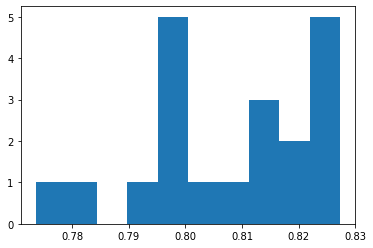

In [67]:
# plot LR
plt.hist(acc_lr);

In [70]:
# KNeighborsClassifier

acc_kn = resultados
np.mean(acc_kn) # Resultado : 0.7928230966896759

0.7928230966896759

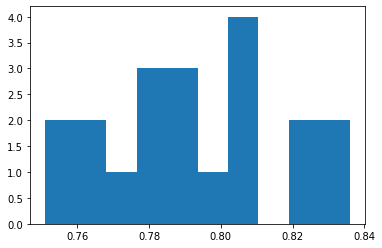

In [71]:
# plot kn

plt.hist(acc_kn);

In [64]:
# LGBMClassifier

acc_lgbm = resultados
np.mean(acc_lgbm) # Resultado : 0.8181886431198668

0.8181886431198668

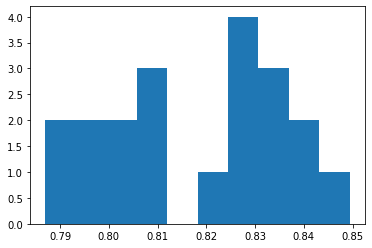

In [65]:
# plot lgbm

plt.hist(acc_lgbm);

In [73]:
#Random Forest:

acc_rf = resultados
np.mean(acc_rf) # Resultado : 0.8159434675265782

0.8159434675265782

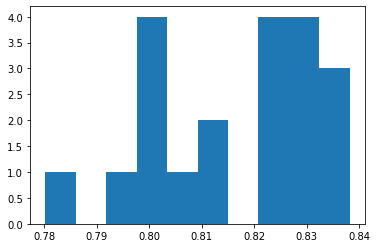

In [74]:
# plot rf

plt.hist(acc_rf);

Como podemos observar acima, criamos uma ótima maneira de validar nossos dados e conseguimos assim verificar o desempenho de vários algoritmos, podemos também ver que há uma certa variação nos gráficos que plotamos, poderíamos trabalhar mais os dados criando *feature* e aplicando técnicas diferentes a fim de aumentar a capacidade de generalização dos modelos.

De acordo com os teste o modelo *LGBMClassifier* obteve o maior *score* chegando próximo a 82%. Vale lembrar que ao contrário do *notebook* inicial nossos testes agora são validados com **dados que nosso modelo nunca viu**, dando assim uma maior confiança.

## Ajustando os Hiperparâmetros

Agora que já sabemos que o modelo com melhor *score* é o *LGBMClassifier*, aplicaremos uma maneira de ajustar alguns dos hiperparâmetros que escolheremos.

Devo admitir que o modelo escolhido tenha recomendação para conjuntos de dados maiores devido a grande sensibilidade, no entanto, servirá como aprendizado em nossa jornada.

Caso queira, não deixe de [visitar a documentação](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html).

Poderíamos aplicar o método *GridSearch*, mas é exaustivo porque o modelo vai testar todas as combinações de todos os parâmetros. Utilizaremos o *Random Search* e a Otimização Bayesiana.

O LightGBM é um algoritmo relativamente novo e muito popular devido a sua grande precisão e pouco uso de memória. LightGBM tem uma característica de crescer árvore em folhas, enquanto outros algoritmos cresce em nível. Ele escolherá a folha com perda máxima  para crescer. Ao cultivar a mesma folha, o algoritmo pode reduzir mais perdas do que um algoritmo em nível.



### Random Search


Na *Random Search* nós escolhemos faixas de valores que ele deverá usar em cada hiperparâmetro. Sendo assim, o algoritmo vai selecionar um valor aleatoriamente da faixa passada para cada hiperparâmetro e rodar o modelo, obtendo uma avaliação. vamos usar o número de chamadas iguais a 30, assim, ele irá realizar essa operação 30 vezes e retornar qual a configuração que obteve o melhor resultado.

Abaixo, você pode ver o código do ajuste do hiperparâmetro para: learning_rate, num_leaves, min_child_samples, subsample e colsample_bytree.

Obs.: Devo lembrar que trarei algumas informações sobre as faixas escolhidas no artigo que irei publicar, no entanto, podes ler a [documentação](https://scikit-optimize.github.io/dev/) para mais informações.

In [77]:
def treinar_model(params): # criando a função para atribuição dos HP
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    mdl = LGBMClassifier(learning_rate=learning_rate, 
                         num_leaves=num_leaves, 
                         min_child_samples=min_child_samples, 
                         subsample=subsample, 
                         colsample_bytree=colsample_bytree, 
                         random_state=1, 
                         subsample_freq=1, 
                         n_estimators=100)
    mdl.fit(x_train, y_train)
    
    pred = mdl.predict(x_valid)
    return -roc_auc_score(y_valid, pred)

space = [(1e-3, 1e-1, 'log-uniform'),# learning_rate
         (2, 128),#num_leaves
         (1, 100),#min_child_samples
         (0.05, 1.0),#subsample
         (0.1, 1.0)]#colsample_bytree

resultado = dummy_minimize(treinar_model, space, random_state=1, verbose=1, n_calls=30)

Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, 74, 10, 0.3372159440002478, 0.23208030173540176] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2635
Function value obtained: -0.8117
Current minimum: -0.8117
Iteration No: 2 started. Evaluating function at random point.
[0.001529949829431263, 78, 72, 0.3782826906908954, 0.457090726807603] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0200
Function value obtained: -0.5000
Current minimum: -0.8117
Iteration No: 3 started. Evaluating function at random point.
[0.01195730942971637, 128, 19, 0.5483207515942279, 0.49910760440160107] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0189
Function value obtained: -0.7688
Current minimum: -0.8117
Iteration No: 4 started. Evaluating function at random point.
[0.0028784217488024557, 16, 51, 0.9182639233502714, 0.5114843271882895] 

Iteration No: 4 ended. Evaluation done at random point.
Time

como resultado obtemos um *ROC AUC Score* de 0.8380, e podemos plotar os parâmetros finais abaixo:

In [78]:
# Resultado no Random search

resultado.x

[0.024753483395116363, 45, 7, 0.7676898999723432, 0.7784885696151218]

### Otimização Bayesiana

Vamos aplicar também a otimização Bayesiana e comparar os melhores resultados.

A otimização Bayesiana funciona construindo uma distribuição com base no Teorema do Limite Central, na qual, descreve o comportamento da função de otimização a medida que o número de observações vai aumentando, neste caso, ela tende a melhorar pois o algoritmo avalia quais regiões no espaço de parâmetros valem a pena explorar e quais não.

Abaixo você pode ver o código utlizado, onde aplicamos as mesmas faixas criadas anteriormente.

In [79]:
resultado_gp = gp_minimize(treinar_model, space, random_state=1, verbose=1, n_calls=30, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, 120, 14, 0.9990884895579377, 0.3124800792567785] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0432
Function value obtained: -0.8210
Current minimum: -0.8210
Iteration No: 2 started. Evaluating function at random point.
[0.006210998932353835, 51, 67, 0.9387621172657304, 0.8616798250174156] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0153
Function value obtained: -0.7734
Current minimum: -0.8210
Iteration No: 3 started. Evaluating function at random point.
[0.004232013397179603, 68, 45, 0.2680983530433343, 0.5809725180523154] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0106
Function value obtained: -0.5000
Current minimum: -0.8210
Iteration No: 4 started. Evaluating function at random point.
[0.0672858974212934, 60, 44, 0.9421713999524447, 0.8005503127028804] 

Iteration No: 4 ended. Evaluation done at random point.
Time ta

Podemos verificar os parâmetros finais para o *ROC AUC Score* de 0.8220.

In [80]:
# Parâmetros do resultado final da otimização Bayesiana

resultado_gp.x

[0.1, 128, 1, 1.0, 0.2431942021997947]

Por último, vamos plotar a convergencia entre os dois métodos.

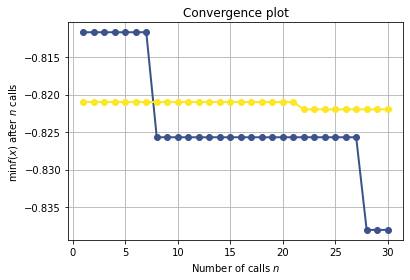

In [81]:
plot_convergence(resultado, resultado_gp);

Agora que você sabe os melhores parâmetros você pode substituir no seu modelo, treinar e criar o arquivo de submissão. 

Recomendo você tentar fazer também para o modelo *Random Forest Classifier*, será importante a prática. 


## Conclusões

Espero que este *Notebook* tenha contribuido em algo para seu aprendizado.

A parte mais importante foi aplicar os métodos de validação cruzada, *Random Search* e Otimização Bayesiana. Desculpas por toda a volta até chegamos de fato a eles, não queria que caíssemos de paraquedas, por isso, usei a continuação do *Notebook* anterior.

Caso você queira ler o artigo desse *Notebook* pode acessar meu blog no [Medium](https://medium.com/@jair.oliveira1204) e também podem me adicionar no [LikedIn](https://www.linkedin.com/in/jairjloliveira/).
